In [2]:
import numpy as np
import scipy.special as sc_special
import tensorflow as tf 
from 	tensorflow import keras
import pandas as pd
from tensorflow.keras import optimizers,metrics,layers,Sequential
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# 原始一次预测数据删除不是当天

In [5]:
data = pd.read_csv('DATASETS/Three.csv',sep=',',header=0)
data.head()

,Time1,Time2,temp_2m,temp_0,BS,humi,w_speed,w_dir,rain,cloud,...,QRTL,CBFS,DBFS,sunFS,SO2,NO2,PM10,PM2.5,O3,CO
0,2020/7/24,2020/7/25 0:00,30.2165,304.435,0.016435,56.9404,4.81518,201.140,0.0,0.073442,...,1.430440,431.124,0.0,0.0,2.67349,22.4139,5.04366,3.27618,5.46107,0.122873
1,2020/7/24,2020/7/25 1:00,29.8274,303.890,0.016727,59.3610,4.75534,204.581,0.0,0.103564,...,1.305580,427.409,0.0,0.0,2.44007,22.5081,4.73870,3.00419,4.61825,0.123913
2,2020/7/24,2020/7/25 2:00,29.5209,303.402,0.016852,60.9493,4.21067,208.949,0.0,0.126546,...,1.131880,421.227,0.0,0.0,3.16628,24.7563,5.88699,3.62919,1.55371,0.136303
3,2020/7/24,2020/7/25 3:00,29.3981,303.168,0.016861,61.4466,3.27305,217.361,0.0,0.066029,...,1.004880,422.500,0.0,0.0,2.07409,19.4554,5.55500,3.41079,2.87538,0.122332
4,2020/7/24,2020/7/25 4:00,28.9494,302.721,0.018765,70.3135,3.56504,223.663,0.0,0.054097,...,0.737696,423.147,0.0,0.0,1.21389,16.3884,5.17156,3.04472,4.99415,0.111185


In [32]:
for i in range(0,len(data)):
    if data['Time2'][i].split('/')[2].split(' ')[0] != data['Time1'][i].split('/')[2]:
        data.drop(index=[i],inplace = True)

In [34]:
data.to_csv('NewThree.csv')

In [35]:
len(data)

8424

# 手动处理，加入实测数据

# 污染物相减 

In [434]:
data = pd.read_csv('NewThreeBC.csv',sep=',',header=0)
data.head()

,SO21,NO21,PM101,PM2.51,O31,CO1,temp_2m,temp_0,BS,humi,...,QRTL,CBFS,DBFS,sunFS,SO2,NO2,PM10,PM2.5,O3,CO
0,9,9,14.0,5,36,0.4,29.1143,302.859,0.019923,73.8026,...,0.608108,430.665,0.0,0.0,0.039888,1.26742,4.23814,2.13777,25.8596,0.076385
1,8,8,8.0,4,33,0.4,28.9890,302.627,0.020002,74.6732,...,0.523890,430.209,0.0,0.0,0.036191,1.23371,4.56836,2.40459,24.6701,0.075858
2,8,10,11.0,5,30,0.4,28.8671,302.767,0.019887,74.8061,...,0.687334,451.661,0.0,0.0,0.050255,1.84691,5.06645,2.67897,23.4993,0.076176
3,9,11,12.0,5,26,0.4,28.2083,301.977,0.020368,79.8176,...,1.811340,429.647,0.0,0.0,0.061901,3.07180,5.66022,2.98245,21.3877,0.076902
4,9,14,12.0,5,20,0.4,27.6341,301.421,0.020459,83.1133,...,0.786867,425.870,0.0,0.0,0.124433,6.77660,7.23576,3.88890,17.4381,0.078260


In [435]:
pollution1 = np.array(data.iloc[:,0:6])
pollution2 = np.array(data.iloc[:,-6:])

In [438]:
#保存污染物相减后的数据，在将之前处理的预测环境数据手动添加进去
pol = pd.DataFrame(pollution1-pollution2,columns = ['SO2','NO2','PM10','PM2.5','O3','CO'])
pol.head()
pol.to_csv('pollution_diffBC.csv')

# 导入处理好的数据，若已处理好代码从这里开始

In [158]:
#数据的各个Y是差值（实测值 - 一次预测值）
data = pd.read_csv('pollution_diffBC.csv',sep=',',header=0)
#data = data.sample(frac = 1) #打乱数据
data.head()

,SO2,NO2,PM10,PM2.5,O3,CO,temp_2m,temp_0,BS,humi,...,w_dir,rain,cloud,high,press,GRTL,QRTL,CBFS,DBFS,sunFS
0,8.960112,7.73258,9.76186,2.86223,10.1404,0.323615,29.1143,302.859,0.019923,73.8026,...,144.959,0.000000,0.051652,648.2680,100.511,13.32600,0.608108,430.665,0.0,0.0
1,7.963809,6.76629,3.43164,1.59541,8.3299,0.324143,28.9890,302.627,0.020002,74.6732,...,146.963,0.000000,1.000000,545.5520,100.509,9.53918,0.523890,430.209,0.0,0.0
2,7.949745,8.15309,5.93355,2.32103,6.5007,0.323824,28.8671,302.767,0.019887,74.8061,...,160.350,0.000000,0.855433,172.0020,100.513,13.83090,0.687334,451.661,0.0,0.0
3,8.938099,7.92820,6.33978,2.01755,4.6123,0.323098,28.2083,301.977,0.020368,79.8176,...,166.460,0.724568,0.862198,87.1468,100.514,8.37547,1.811340,429.647,0.0,0.0
4,8.875567,7.22340,4.76424,1.11110,2.5619,0.321740,27.6341,301.421,0.020459,83.1133,...,149.578,3.712180,0.872415,54.2559,100.541,7.43824,0.786867,425.870,0.0,0.0


In [159]:
#各污染物浓度分别建模，自变量X不变（所有环节情况）
SO2X = data.iloc[:7900,[6,7,9,10,11,12,14,16,18]] 
SO2TestX = data.iloc[7900:,[6,7,9,10,11,12,14,16,18]]
NO2X = data.iloc[:7900,[6,7,9,10,11,12,14,18]]
NO2TestX =data.iloc[7900:,[6,7,9,10,11,12,14,18]]
PM10X =data.iloc[:7900,[6,7,10,12,14,16,18]]
PM10TestX =data.iloc[7900:,[6,7,10,12,14,16,18]]
PM2_5X =data.iloc[:7900,[6,7,9,10,11,12,18]]
PM2_5TestX =data.iloc[7900:,[6,7,9,10,11,12,18]]
O3X =data.iloc[:7900,[6,7,10,12,14,16,18]]
O3TestX =data.iloc[7900:,[6,7,10,12,14,16,18]]
COX =data.iloc[:7900,[6,7,9,10,12,14]]
COTestX =data.iloc[7900:,[6,7,9,10,12,14]]


SO2Y = data.iloc[:7900,0]
SO2TestY = data.iloc[7900:,0]
NO2Y = data.iloc[:7900,1]
NO2TestY = data.iloc[7900:,1]
PM10Y = data.iloc[:7900,2]
PM10TestY = data.iloc[7900:,2]
PM2_5Y = data.iloc[:7900,3]
PM2_5TestY = data.iloc[7900:,3]
O3Y = data.iloc[:7900,4]
O3TestY = data.iloc[7900:,4]
COY = data.iloc[:7900,5]
COTestY = data.iloc[7900:,5]

inputnums = [SO2X.shape[1],NO2X.shape[1],PM10X.shape[1],PM2_5X.shape[1],O3X.shape[1],COX.shape[1]]  #!!!!!!!!!!!!!!!!!!输入层结构
inputnum = inputnums[2]
outputnum = 1
hiddnum1 = 15
hiddennum = hiddnum1 
numsum = inputnum*hiddennum+hiddennum+hiddennum*outputnum+outputnum #6*10+10+10*3+3=103

LossArr = []

In [160]:
PM10X

,temp_2m,temp_0,w_speed,rain,high,GRTL,CBFS
0,29.1143,302.859,4.75900,0.000000,648.2680,13.32600,430.665
1,28.9890,302.627,4.07305,0.000000,545.5520,9.53918,430.209
2,28.8671,302.767,3.70429,0.000000,172.0020,13.83090,451.661
3,28.2083,301.977,2.50681,0.724568,87.1468,8.37547,429.647
4,27.6341,301.421,1.81650,3.712180,54.2559,7.43824,425.870
...,...,...,...,...,...,...,...
7895,30.9836,314.437,7.37757,0.031471,934.4580,379.59600,438.444
7896,28.6230,310.312,10.74850,3.457400,624.6730,410.63200,462.998
7897,29.5915,307.197,4.61316,28.473800,596.5910,111.68300,459.160
7898,29.3358,304.585,5.88498,0.000000,590.2840,59.27370,433.123


In [161]:
PM10Y.describe()

count    7900.000000
mean       14.266261
std        24.088336
min      -151.768000
25%         1.942770
50%        12.747950
75%        26.200285
max       212.754300
Name: PM10, dtype: float64

In [162]:
PM10max,PM10mean

(212.7543, 14.266260983417673)

# 注意每次换数据的神经网络结构


In [176]:
#零均值处理

SO2max = np.max(np.abs(SO2Y),axis=0)
SO2mean = np.mean(SO2Y,axis=0)
NO2max = np.max(np.abs(NO2Y),axis=0)
NO2mean = np.mean(NO2Y,axis=0)
PM10max = np.max(np.abs(PM10Y),axis=0)
PM10mean = np.mean(PM10Y,axis=0)
PM2_5max = np.max(np.abs(PM2_5Y),axis=0)
PM2_5mean = np.mean(PM2_5Y,axis=0)
O3max = np.max(np.abs(O3Y),axis=0)
O3mean = np.mean(O3Y,axis=0)

def data_progress(X,TestX):
    for i in range(0,X.shape[1]):
        X.iloc[:,i] -= np.mean(X,axis=0)[i]
        X.iloc[:,i] /= np.max(np.abs(X),axis=0)[i]
        TestX.iloc[:,i] -= np.mean(TestX,axis=0)[i]
        TestX.iloc[:,i] /= np.max(np.abs(TestX),axis=0)[i]
        
    return 0
def data_progressY(Y,TestY):
    Y -= np.mean(Y,axis=0)
    Y /= np.max(np.abs(Y),axis=0)
    TestY -= np.mean(TestY,axis=0)
    TestY /= np.max(np.abs(TestY),axis=0)
    return 1
    
data_progress(SO2X,SO2TestX)
data_progressY(SO2Y,SO2TestY)
data_progress(NO2X,NO2TestX)
data_progressY(NO2Y,NO2TestY)
data_progress(PM10X,PM10TestX)
data_progressY(PM10Y,PM10TestY)
data_progress(PM2_5X,PM2_5TestX)
data_progressY(PM2_5Y,PM2_5TestY)
data_progress(O3X,O3TestX)
data_progressY(O3Y,O3TestY)
data_progress(COX,COTestX)
data_progressY(COY,COTestY)

1

In [177]:
print(SO2max,SO2mean,NO2max,NO2mean,PM10max,PM10mean,PM2_5max,PM2_5mean,O3max,O3mean)

1.0 -2.1718490885823235e-16 1.0 -9.219067141191173e-18 212.7543 14.266260983417673 1.0 1.1128189168488643e-16 1.0 1.8235764515868393e-16


In [178]:
PM10Y.dropna()

0      -0.022694
1      -0.054586
2      -0.041981
3      -0.039934
4      -0.047872
          ...   
7895    0.029092
7896   -0.138225
7897   -0.089301
7898   -0.120967
7899   -0.042312
Name: PM10, Length: 7900, dtype: float64

In [179]:
len(PM10X),len(PM10Y)

(7900, 7900)

In [180]:
a = np.isnan(PM10Y)
a = np.array(a)
a[0] 

False

In [181]:

for i in range(0,len(PM10Y)):
    if a[i]==True:
        print(i)

# 智能算法优化

In [182]:

#n：布谷鸟数  m：布谷鸟的维度
def cuckoo_search(n, m, lower_boundary, upper_boundary, iter_num = 20,pa = 0.25, beta = 1.5, step_size = 0.1,alpha=0.77,xn=0.33):

    num=1
    # get initial nests' locations 
    nests,best_nest,best_fitness,lossness = generate_nests(n, m,alpha,xn, lower_boundary, upper_boundary) #alpha,xn用于tent初始化阈值和初值设置
    
    # get the best nest and record it
    LossArr.append(best_fitness) #全局变量，保存每代最佳适应度值
    

    print('\r\n BEST_LOSSNESS IS %.2f : \r\n',best_fitness)

    for _ in range(iter_num):
        
        print('\r\n******************************************************第 %d 代开始迭代优化************************************************************\r\n'%num)
        nests = update_nests(lower_boundary, upper_boundary, nests, best_nest, lossness, step_size,best_fitness)
        nests = abandon_nests(nests, lower_boundary, upper_boundary, pa)
        
        print('\r\n*****************************************************第 %d 次迭代，计算适应度********************************************************\r\n'%num)
        lossness,_ = calc_fitness( nests)
        print('\r\n*********************************************************第 %d 次迭代结束************************************************************\r\n'%num)
        
        min_loss_index = np.argmin(lossness)
        min_loss = lossness[min_loss_index]
        min_nestloss = nests[min_loss_index]
        LossArr.append(min_loss)
            
        if min_loss < best_fitness  : #and  min_loss_fit > best_two_fitness
            best_nest = min_nestloss
            best_fitness = min_loss
            print('\r\n******')
            print('\r\n 第 %d 次迭代最优Loss是 %.2f : \r\n'%(num,best_fitness))
            print('\r\n******\r\n')
        num+=1

    return (best_nest, best_fitness)

In [183]:
def generate_nests(n, m,alpha,xn, lower_boundary, upper_boundary):

# #随机生成nest
#     lower_boundary = np.array(lower_boundary)
#     upper_boundary = np.array(upper_boundary)
#     nests = np.empty((n, m))

#     for each_nest in range(n):
#         nests[each_nest] = lower_boundary + np.array([np.random.rand() for _ in range(m)]) * (upper_boundary - lower_boundary)

#Tent混沌反向初始化

# #混沌初始化
    nests = np.empty((n, m))
    sig_nest = np.empty(m)
    alpha = alpha
    xn = xn
    for i in range(0,n):   #*2 值域为【-1,1】 *6 值域为[-3,3]
        for j in range(0,m):
            if 0<=xn<alpha:
                xn = xn/alpha
                sig_nest[j]=(xn-0.5)*6
            elif alpha <= xn <= 1:
                xn = (1-xn)/(1-alpha)
                sig_nest[j] = (xn-0.5)*6
            nests[i] = sig_nest
            
# #反向初始化            
    renests = -1 * nests   #定义：Pi = ai + bi - pi  生成反向nests
    
# #拼接两个初始化nests
    nests = np.vstack((nests,renests))  #拼接nests和renests 准备计算适应度选择最优的n个nest
    
#计算适应度
    lossness,_ = calc_fitness( nests) 
    
# #根据loss值排序
    arrIndex = np.argsort(lossness)   #获得排序数组  从小到大
    lossness = lossness[arrIndex]     #将lossness数组按照从小到大排序
    nests = nests[arrIndex]    #将nests也按照相同序列进行排序，保证和lossness对齐
    
#删除多余的n组nest，这里从最底下开始一个个删，因为已经排好序了，所以删除的为效果最差的
    for i in range(n):
        nests = np.delete(nests,-1,0)
        lossness = np.delete(lossness,-1,0)
#现在的nests是按照loss排序的，第一个loss最小

    return nests,nests[0],lossness[0],lossness

In [184]:
def update_nests(lower_boundary, upper_boundary, nests, best_nest, lossness, step_coefficient,bestfitness):

    lower_boundary = np.array(lower_boundary)
    upper_boundary = np.array(upper_boundary)
    n, m = nests.shape
    # 莱维飞行生成步长：较长时间的短步长和较短时间的长步长
    #生成的步长的shape也是n*m，保证所有元素得到更新
    #这个步长通过step_size来控制大小
    steps = levy_flight(n, m, 1.5)
    new_nests = nests.copy()

    for each_nest in range(n):
        # coefficient 0.01 is to avoid levy flights becoming too aggresive
        # and (nest[each_nest] - best_nest) 保留了最佳nest，但会导致局部最优
        step_size = step_coefficient * steps[each_nest] # * (nests[each_nest] - best_nest)
        step_direction = np.random.rand(m) #0-1均匀概率分布生成方向
        #新的布谷鸟在原来的基础上加上步长和方向
        new_nests[each_nest] += step_size * step_direction  
        # apply boundary condtions
        new_nests[each_nest][new_nests[each_nest] < lower_boundary] = lower_boundary[new_nests[each_nest] < lower_boundary]
        new_nests[each_nest][new_nests[each_nest] > upper_boundary] = upper_boundary[new_nests[each_nest] > upper_boundary]

    new_losses,new_nests = calc_fitness(new_nests)
    #适应度更好的才更新过去
    
    nests[new_losses < lossness] = new_nests[new_losses < lossness] 
    return nests

In [185]:
def abandon_nests(nests, lower_boundary, upper_boundary, pa):

    lower_boundary = np.array(lower_boundary)
    upper_boundary = np.array(upper_boundary)
    n, m = nests.shape
    for each_nest in range(n):  
        #pa概率抛弃，抛弃后重新生成
        if (np.random.rand() < pa):
            #局部随机行走生成步长
            #随机两个种群相差*一个0-1的随机数
            step_size = np.random.rand() * (nests[np.random.randint(0, n)] - nests[np.random.randint(0, n)])
            nests[each_nest] += step_size
            # apply boundary condtions
            nests[each_nest][nests[each_nest] < lower_boundary] = lower_boundary[nests[each_nest] < lower_boundary]
            nests[each_nest][nests[each_nest] > upper_boundary] = upper_boundary[nests[each_nest] > upper_boundary]
    
    return nests

In [186]:
def levy_flight(n, m, beta):

    sigma_u = (sc_special.gamma(1+beta)*np.sin(np.pi*beta/2)/(sc_special.gamma((1+beta)/2)*beta*(2**((beta-1)/2))))**(1/beta)
    sigma_v = 1

    u =  np.random.normal(0, sigma_u, (n, m))
    v = np.random.normal(0, sigma_v, (n, m))

    steps = u/((np.abs(v))**(1/beta))

    return steps

In [187]:
def calc_fitness(nests):
    
    n, m = nests.shape
    lossness = np.empty(n)
    new_nests = nests
    for Sig_nest in range(n):
        chrom = nests[Sig_nest]
        #分解模型参数
        w1 = chrom[:inputnum*hiddennum]
        w1 = w1.reshape(inputnum,hiddennum)
        b1 = chrom[inputnum*hiddennum:inputnum*hiddennum+hiddennum]
        w2 = chrom[inputnum*hiddennum+hiddennum:inputnum*hiddennum+hiddennum+hiddennum*outputnum]
        w2 = w2.reshape(hiddennum,outputnum)
        b2 = chrom[inputnum*hiddennum+hiddennum+hiddennum*outputnum:]

        WB_l1 = (w1,b1)
        WB_l2 = (w2,b2)
        #创建模型，并赋予参数
        model = keras.Sequential([
            keras.layers.Dense(hiddennum,activation='relu',name='l1'),
            keras.layers.Dense(outputnum,name='l2')
        ])
        model.build(input_shape=[None,inputnum])
        
        #model.summary()
        model.compile(optimizer=optimizers.Adam(lr=0.01),
                    loss='mse',)
        
        layer1 = model.get_layer('l1')
        layer2 = model.get_layer('l2')
        layer1.set_weights(WB_l1)
        layer2.set_weights(WB_l2)
        
        #训练模型
        #！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！下面两句输入数据集
        model.fit(PM10X,PM10Y,epochs=1)
        loss = model.evaluate(PM10X,PM10Y)  #这里是用验证集评估，其实应该用测试集吧 evaluate产生两个结果，前面是损失，后面是准确率
        lossness[Sig_nest] = loss
        
        
        (k1,y1) = layer1.get_weights()  #获取训练后的神经网络权值，并赋值给c
        (k2,y2) = layer2.get_weights()
        c=k1.reshape(1,-1).tolist()[0] + y1.reshape(1,-1).tolist()[0] + k2.reshape(1,-1).tolist()[0] + y2.reshape(1,-1).tolist()[0]
        new_nests[Sig_nest] = c
        
        
#         if(acc>bestfitness): #在计算适应度的过程当中，发现有更好的适应度就把参数保存
#             #model.save_weights('my_model_fun.h5')
#             bestfitness = acc
    return lossness,new_nests

In [188]:
# if __name__=='__main__':
low = -10*np.ones(numsum)
upp = 10*np.ones(numsum)
nest,loss = cuckoo_search(10,numsum, low,upp, step_size = 0.3,alpha=0.77,xn=0.33)
loss

247/247 [==============================] - 0s 695us/step - loss: 0.2578

 BEST_LOSSNESS IS %.2f : 
 0.07641486078500748

******************************************************第 1 代开始迭代优化************************************************************

247/247 [==============================] - 0s 735us/step - loss: 0.1040

*****************************************************第 1 次迭代，计算适应度********************************************************

247/247 [==============================] - 0s 878us/step - loss: 9.5731

*********************************************************第 1 次迭代结束************************************************************


******

 第 1 次迭代最优Loss是 0.02 : 


******


******************************************************第 2 代开始迭代优化************************************************************

247/247 [==============================] - 0s 646us/step - loss: 1.8526

*****************************************************第 2 次迭代，计算适应度********************************************

247/247 [==============================] - 0s 760us/step - loss: 0.0576

*****************************************************第 5 次迭代，计算适应度********************************************************

247/247 [==============================] - 0s 638us/step - loss: 0.0349

*********************************************************第 5 次迭代结束************************************************************


******

 第 5 次迭代最优Loss是 0.01 : 


******


******************************************************第 6 代开始迭代优化************************************************************

247/247 [==============================] - 0s 601us/step - loss: 1.8689

*****************************************************第 6 次迭代，计算适应度********************************************************

247/247 [==============================] - 0s 605us/step - loss: 1.1377

*********************************************************第 6 次迭代结束************************************************************


******

 第 6 次迭代最优Loss是 0.01 : 


247/247 [==============================] - 0s 593us/step - loss: 0.0450

*****************************************************第 10 次迭代，计算适应度********************************************************

247/247 [==============================] - 0s 796us/step - loss: 0.1802

*********************************************************第 10 次迭代结束************************************************************


******************************************************第 11 代开始迭代优化************************************************************

247/247 [==============================] - 0s 764us/step - loss: 0.2137

*****************************************************第 11 次迭代，计算适应度********************************************************

247/247 [==============================] - 0s 605us/step - loss: 0.0404

*********************************************************第 11 次迭代结束************************************************************


******

 第 11 次迭代最优Loss是 0.01 : 


******


**************************

247/247 [==============================] - 0s 593us/step - loss: 0.1137

*****************************************************第 15 次迭代，计算适应度********************************************************

247/247 [==============================] - 0s 565us/step - loss: 0.0843

*********************************************************第 15 次迭代结束************************************************************


******************************************************第 16 代开始迭代优化************************************************************

247/247 [==============================] - 0s 630us/step - loss: 0.1548

*****************************************************第 16 次迭代，计算适应度********************************************************

247/247 [==============================] - 0s 557us/step - loss: 0.0528

*********************************************************第 16 次迭代结束************************************************************


******************************************************第 17 代开始迭代优化****

247/247 [==============================] - 0s 561us/step - loss: 0.1136

*****************************************************第 20 次迭代，计算适应度********************************************************

247/247 [==============================] - 0s 573us/step - loss: 0.0261

*********************************************************第 20 次迭代结束************************************************************



0.01339342538267374

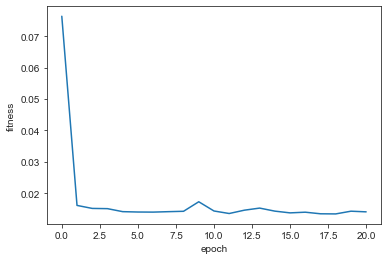

In [193]:
sns.set_style("ticks")
x = list(range(0,len(LossArr)))
fig = sns.lineplot(x,LossArr)
plt.xlabel("epoch")
plt.ylabel("fitness")
scatter_fig = fig.get_figure()
scatter_fig.savefig('./PM10Loss', dpi = 400)

#  神经网络搭建

In [194]:
PM10X

,temp_2m,temp_0,w_speed,rain,high,GRTL,CBFS
0,0.287965,0.108122,0.076231,-0.006268,0.116345,-0.224027,0.275069
1,0.281659,0.098634,-0.004824,-0.006268,0.051565,-0.234158,0.272116
2,0.275525,0.104359,-0.048398,-0.006268,-0.184023,-0.222677,0.411023
3,0.242371,0.072053,-0.189896,0.003285,-0.237538,-0.237271,0.268477
4,0.213475,0.049315,-0.271466,0.042676,-0.258282,-0.239779,0.244020
...,...,...,...,...,...,...,...
7895,0.382036,0.581600,0.385651,-0.005853,0.296837,0.755831,0.325440
7896,0.263241,0.412909,0.783973,0.039316,0.101464,0.838860,0.484433
7897,0.311980,0.285523,0.058998,0.369148,0.083754,0.039101,0.459581
7898,0.299112,0.178706,0.209281,-0.006268,0.079776,-0.101107,0.290985


In [195]:
PM10Y

0      -0.022694
1      -0.054586
2      -0.041981
3      -0.039934
4      -0.047872
          ...   
7895    0.029092
7896   -0.138225
7897   -0.089301
7898   -0.120967
7899   -0.042312
Name: PM10, Length: 7900, dtype: float64

In [196]:
chrom = nest
w1 = chrom[:inputnum*hiddennum]
w1 = w1.reshape(inputnum,hiddennum)
b1 = chrom[inputnum*hiddennum:inputnum*hiddennum+hiddennum]
w2 = chrom[inputnum*hiddennum+hiddennum:inputnum*hiddennum+hiddennum+hiddennum*outputnum]
w2 = w2.reshape(hiddennum,outputnum)
b2 = chrom[inputnum*hiddennum+hiddennum+hiddennum*outputnum:]

WB_layer1 = (w1,b1)
WB_layer2 = (w2,b2)

model = keras.Sequential([
    keras.layers.Dense(12,name='layer1',activation='relu'),
    #keras.layers.Dense(hiddnum2,activation='relu'),
    #keras.layers.Dense(5,activation = 'relu'),
    keras.layers.Dense(outputnum,name='layer2')
    ])


model.build(input_shape=[None,inputnum])
#model.summary()
model.compile(optimizer=optimizers.Adam(lr=0.0005),
            loss='mse',)

layer1 = model.get_layer('layer1')
layer2 = model.get_layer('layer2')
layer1.set_weights(WB_layer1)
layer2.set_weights(WB_layer2)

    
model.fit(PM10X,PM10Y,epochs=50)  #！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！

ValueError: Layer weight shape (7, 12) not compatible with provided weight shape (7, 15)

In [197]:
pre = model.predict(PM10TestX)  #！！！！！！！！！！！！！！！！！！！！！！！！！！！
pre = np.squeeze(pre)
print(pre)

[-0.16566071 -0.17314962 -0.250751   ... -0.430403   -0.4669847
 -0.28404337]


In [198]:
print(np.array(PM10TestY))#！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！

[-0.01007248  0.00406857  0.00800054 ... -0.00116247 -0.04020262
 -0.01670594]


# 第三问预测

In [199]:
#！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！最后一个数字
predata = pd.read_csv('pre_threeBC.csv',sep=',',header=0,usecols=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,17])
predata.head()

,temp_2m,temp_0,BS,humi,w_speed,w_dir,rain,cloud,high,press,GRTL,QRTL,CBFS,DBFS,sunFS,PM10
0,28.5312,302.609,0.020101,77.2135,2.75267,169.549,0.0,0.786019,124.0780,100.521,13.95230,0.345500,427.620,0.0,0.0,12.6404
1,28.3903,302.184,0.020023,77.5756,2.67352,162.283,0.0,0.528925,81.1448,100.506,9.14611,0.306452,425.813,0.0,0.0,12.6656
2,27.8752,301.602,0.019788,79.1370,2.54873,178.090,0.0,0.441060,51.8090,100.476,7.81386,0.250613,422.467,0.0,0.0,11.4006
3,27.5799,301.206,0.019901,81.0852,2.71625,170.937,0.0,0.356945,37.8650,100.498,6.69182,0.200927,421.219,0.0,0.0,10.7583
4,27.5357,300.952,0.019849,81.0702,2.31988,187.291,0.0,0.246818,23.5657,100.469,3.11452,0.141514,419.860,0.0,0.0,12.9891


In [200]:
predata.shape

(144, 16)

In [201]:
# preX = predata.iloc[:,[0,1,3,4,5,6,8,10,12]] 
# SO2 = np.array(predata['SO2'])
# preX.head()

# preX = predata.iloc[:,[0,1,3,4,5,6,8,12]] 
# NO2 = np.array(predata['NO2'])
# preX.head()

preX = predata.iloc[:,[0,1,4,6,8,10,12]] 
PM10 = np.array(predata['PM10'])
preX.head()

# preX = predata.iloc[:,[0,1,3,4,5,6,12]] 
# PM2_5 = np.array(predata['PM2.5'])
# preX.head()

# preX = predata.iloc[:,[0,1,3,4,5,6,12]] 
# O3 = np.array(predata['O3'])
# preX.head()

# preX = predata.iloc[:,[0,1,3,4,6,8]] 
# CO = np.array(predata['CO'])
# preX.head()


# SO2X = data.iloc[:7900,[6,7,9,10,11,12,14,16,18]] 
# SO2TestX = data.iloc[7900:,[6,7,9,10,11,12,14,16,18]]
# NO2X = data.iloc[:7900,[6,7,9,10,11,12,14,18]]
# NO2TestX =data.iloc[7900:,[6,7,9,10,11,12,14,18]]
# PM10X =data.iloc[:7900,[6,7,10,12,14,16,18]]
# PM10TestX =data.iloc[7900:,[6,7,10,12,14,16,18]]
# PM2_5X =data.iloc[:7900,[6,7,9,10,11,12,18]]
# PM2_5TestX =data.iloc[7900:,[6,7,9,10,11,12,18]]
# O3X =data.iloc[:7900,[6,7,10,12,14,16,18]]
# O3TestX =data.iloc[7900:,[6,7,10,12,14,16,18]]
# COX =data.iloc[:7900,[6,7,9,10,12,14]]
# COTestX =data.iloc[7900:,[6,7,9,10,12,14]]

,temp_2m,temp_0,w_speed,rain,high,GRTL,CBFS
0,28.5312,302.609,2.75267,0.0,124.0780,13.95230,427.620
1,28.3903,302.184,2.67352,0.0,81.1448,9.14611,425.813
2,27.8752,301.602,2.54873,0.0,51.8090,7.81386,422.467
3,27.5799,301.206,2.71625,0.0,37.8650,6.69182,421.219
4,27.5357,300.952,2.31988,0.0,23.5657,3.11452,419.860


In [202]:
PM10

array([12.6404 , 12.6656 , 11.4006 , 10.7583 , 12.9891 , 12.4272 ,
       12.3011 ,  8.97106,  7.36999,  6.33996,  5.72278,  5.86559,
        5.64732,  6.47005,  6.19566,  5.30852,  5.12992,  4.87183,
        5.54627,  7.36436,  8.40475,  8.27699,  6.92664,  5.62615,
        5.95491,  6.55772,  6.30853,  6.11577,  6.91394, 10.7955 ,
       10.1176 ,  5.29275,  4.42363,  4.23891,  3.5296 ,  2.95784,
        3.4332 ,  3.61947,  4.02842,  4.27859,  4.11226,  4.02901,
        4.59469,  5.69711,  6.29699,  6.17042,  5.96615,  6.5124 ,
        7.7786 ,  7.69738,  7.34177,  7.22175,  7.47756,  9.13274,
        9.58822,  8.20135,  6.08722,  4.94081,  4.63602,  4.96403,
        4.81744,  4.68961,  4.73865,  4.33011,  3.68003,  3.67611,
        3.6461 ,  3.76426,  4.14473,  4.81406,  5.0627 ,  5.00423,
       18.0022 , 16.1076 , 16.8906 , 17.1666 , 17.7944 , 26.5173 ,
       33.234  , 23.1729 , 18.7495 , 15.7511 , 14.8514 , 14.6306 ,
       14.1599 , 14.8768 , 16.2481 , 16.2047 , 17.3816 , 18.43

In [203]:
#零均值处理
def data_progress(X):
    for i in range(0,X.shape[1]):
        X.iloc[:,i] -= np.mean(X,axis=0)[i]
        X.iloc[:,i] /= np.max(np.abs(X),axis=0)[i]

    return 0
data_progress(preX)
preX

F:\ANA_Router\lib\site-packages\pandas\core\indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,temp_2m,temp_0,w_speed,rain,high,GRTL,CBFS
0,-0.321114,-0.518091,-0.116623,-0.012661,-0.393536,-0.437677,-0.059644
1,-0.343916,-0.551489,-0.147797,-0.012661,-0.423812,-0.456003,-0.102252
2,-0.427278,-0.597225,-0.196947,-0.012661,-0.444499,-0.461083,-0.181147
3,-0.475068,-0.628344,-0.130968,-0.012661,-0.454332,-0.465361,-0.210574
4,-0.482221,-0.648305,-0.287082,-0.012661,-0.464416,-0.479002,-0.242618
...,...,...,...,...,...,...,...
139,0.905698,0.872222,-0.186380,-0.012661,0.726861,0.421118,0.365581
140,0.959282,0.694229,-0.076111,-0.012661,0.835558,0.196028,0.489159
141,0.927271,0.467513,-0.292100,-0.012661,0.965841,-0.091031,0.597081
142,0.660582,0.131251,0.410022,1.000000,0.061924,-0.226707,0.668832


# 预测数据

# 预测值反归一化

In [204]:
pre_two = model.predict(preX)
pre_two = np.squeeze(pre_two)
pre_two = np.array(pre_two)
pre_two

array([-5.63729644e-01, -5.94796419e-01, -6.08629942e-01, -5.72357535e-01,
       -6.67209506e-01, -6.23450279e-01, -6.57201290e-01, -6.94952011e-01,
       -3.94237280e-01, -3.94237280e-01, -6.45716906e-01, -7.51667768e-02,
        2.36434303e-02,  5.19384146e-02,  3.57370600e-02,  6.26760647e-02,
        4.60969768e-02,  4.16997634e-02,  1.38866045e-02,  2.70012021e-03,
       -2.74015628e-02, -1.44876868e-01, -2.35939652e-01, -3.70895147e-01,
       -3.99522185e-01, -5.25079131e-01, -6.77852094e-01, -7.63999283e-01,
       -9.99626398e-01, -8.25071335e-01, -8.93257916e-01, -7.38039136e-01,
       -6.12603724e-01, -3.85544300e-01, -3.85544300e-01, -1.77737981e-01,
       -2.49370635e-02, -2.06453614e-02,  8.48967582e-02,  1.38941072e-02,
        3.60490531e-02,  4.52360809e-02,  3.83058190e-02,  2.70890221e-02,
        7.55587965e-03, -4.49421294e-02, -1.24456413e-01, -1.63641423e-01,
       -2.71198362e-01, -4.68513966e-01, -5.47340274e-01, -6.14567637e-01,
       -6.35575414e-01, -

In [205]:
pre_two = pre_two*PM10max      #！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！！
pre_two = pre_two+PM10mean

In [206]:
#PM2_5#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# 计算最终值 （最终值 = 二次预测值 + 一次预测值）

In [207]:
result = pre_two + PM10  #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
result1 = result[0:24]
result2 = result[24:48]
result3 = result[48:72]
result4 = result[72:96]
result5 = result[96:120]
result6 = result[120:]
len(result1),len(result2),len(result3),len(result4),len(result5),len(result6)

(24, 24, 24, 24, 24, 24)

In [208]:
result2

array([ -64.7788928 ,  -90.88886661, -123.64114651, -142.16209255,
       -191.49461408, -150.47570972, -165.66059824, -137.46198022,
       -111.64418769,  -63.52103873,  -64.23034873,  -20.59041974,
         12.3939935 ,   13.4933418 ,   36.3568311 ,   21.50088195,
         26.04811205,   27.91944236,   27.01067892,   25.72667772,
         22.17079695,   10.8750499 ,   -6.24622659,  -14.03675619])

In [209]:
#去负值
index1 = []
index2 = []
index3 = []
index4 = []
index5 = []
index6 = []
for i in range(0,len(result1)):
    if result1[i] <= 0 :
        index1.append(i)
for i in range(0,len(result2)):
    if result2[i] <= 0 :
        index2.append(i)
for i in range(0,len(result3)):
    if result3[i] <= 0 :
        index3.append(i)
for i in range(0,len(result4)):
    if result4[i] <= 0 :
        index4.append(i)
for i in range(0,len(result5)):
    if result5[i] <= 0 :
        index5.append(i)
for i in range(0,len(result6)):
    if result6[i] <= 0 :
        index6.append(i)

result1 = np.delete(result1, index1)
result2 = np.delete(result2, index2)
result3 = np.delete(result3,index3)
result4 = np.delete(result4,index4)
result5 = np.delete(result5,index5)
result6 = np.delete(result6,index6)
result3

array([ 5.70534417,  9.13628244, 12.70756308, 18.07476942, 21.27341188,
       24.18345329, 25.7088861 , 26.89300413, 27.59934464, 23.35779932,
       19.83650848,  4.44535492])

In [210]:
len(result1),len(result2),len(result3),len(result4),len(result5),len(result6)

(10, 10, 12, 11, 12, 8)

In [211]:
# #去除3个最大最小值

result1 = np.sort(result1)[3:-3]
result2 = np.sort(result2)[3:-3]
result3 = np.sort(result3)[3:-3]
result4 = np.sort(result4)[3:-3]
result5 = np.sort(result5)[3:-3]
result6 = np.sort(result6)[3:-3]

In [212]:
result6

array([28.68227342, 28.71255603])

In [213]:
len(result4),len(result5),len(result6)

(5, 6, 2)

In [214]:
sum(result1)/len(result1),sum(result2)/len(result2),sum(result3)/len(result3)

(25.946454577941896, 23.861617167282105, 19.905584245707193)

In [215]:
sum(result4)/len(result4),sum(result5)/len(result5),sum(result6)/len(result6)

(26.764623296203617, 29.84742616589864, 28.697414726257325)

#  灰色关联

In [104]:
data = pd.read_csv('pollution_diff.csv',sep=',',header=0,usecols=[5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
data.head()

,CO,temp_2m,temp_0,BS,humi,w_speed,w_dir,rain,cloud,high,press,GRTL,QRTL,CBFS,DBFS,sunFS
0,0.367829,30.3199,304.571,0.017091,58.8056,4.63482,207.252,0.0,0.097717,395.412,100.575,24.7565,1.326270,432.925,0.0,0.0
1,0.357214,30.0534,304.251,0.017053,59.6548,3.43828,213.014,0.0,0.107876,411.756,100.587,18.6877,1.176690,433.034,0.0,0.0
2,0.362087,29.7796,303.829,0.017657,62.8256,3.21112,220.031,0.0,0.041136,489.319,100.594,15.0867,1.006060,428.977,0.0,0.0
3,0.382504,29.3158,303.291,0.019127,70.0430,3.86725,222.395,0.0,0.092427,432.893,100.602,15.8745,0.822065,429.196,0.0,0.0
4,0.387636,28.9137,302.841,0.020353,76.4282,4.35292,228.920,0.0,0.128056,414.048,100.624,16.3945,0.631609,430.162,0.0,0.0


In [105]:
list_columns = [str(s) for s in data.columns if s not in [None]]

In [106]:
# 无量纲化
def dimensionlessProcessing(df):
    newDataFrame = pd.DataFrame(index=df.index)
    columns = df.columns.tolist()
    for c in columns:
        d = df[c]
        MAX = d.max()
        MIN = d.min()
        MEAN = d.mean()
        newDataFrame[c] = ((d - MEAN) / (MAX - MIN)).tolist()
    return newDataFrame

def GreyCD_sig(gray, m=0):
    gray = dimensionlessProcessing(gray)
    std = gray.iloc[:, m]  # 标准要素
    gray.drop(str(m),axis=1,inplace=True)
    ce = gray.iloc[:, 0:]  # 比较要素
    shape_n, shape_m = ce.shape[0], ce.shape[1]  # 计算行列

    # 与标准要素比较
    a = np.zeros([shape_m, shape_n])
    for i in range(shape_m):
        for j in range(shape_n):
            a[i, j] = abs(ce.iloc[j, i] - std[j])

    c, d = np.max(a), np.min(a)

    # 计算结果
    result = np.zeros([shape_m, shape_n])
    for i in range(shape_m):
        for j in range(shape_n):
            result[i, j] = (d + 0.5 * c) / (a[i, j] + 0.5 * c)

    # 求均值，取得灰色关联值
    result_list = [np.mean(result[i, :]) for i in range(shape_m)]
    result_list.insert(m,1)
    return pd.DataFrame(result_list)


def GreyCD(DataFrame):
    df = DataFrame.copy()
    list_columns = [
        str(s) for s in range(len(df.columns)) if s not in [None]
    ]
    df_local = pd.DataFrame(columns=list_columns)
    df.columns=list_columns
    for i in range(len(df.columns)):
        df_local.iloc[:, i] = GRA_ONE(df, m=i)[0]
    return df_local


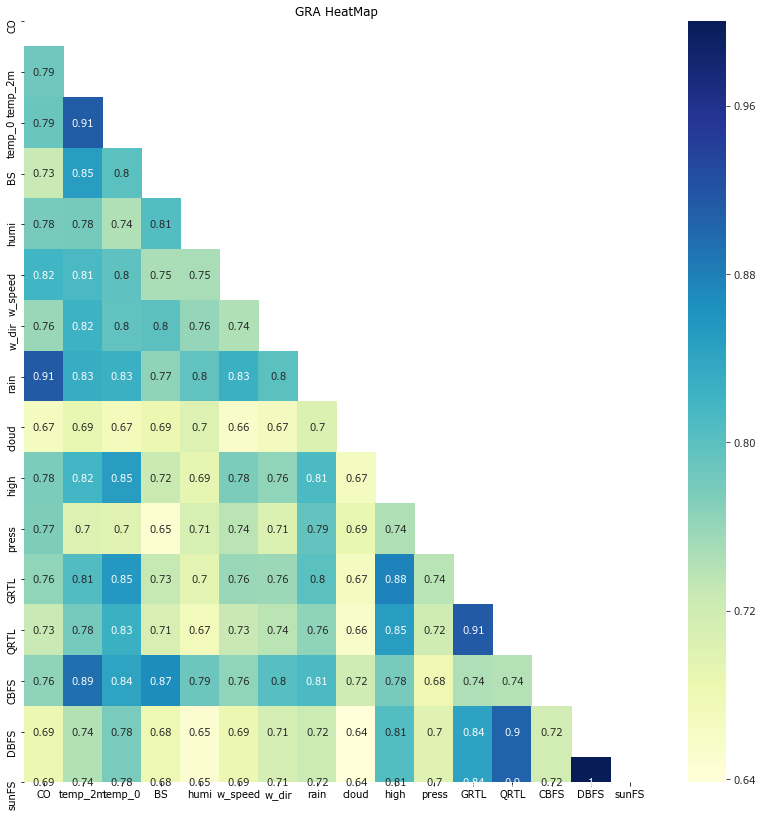

In [107]:
# 灰色关联结果矩阵可视化
# 灰色关联结果矩阵可视化
import seaborn as sns

def ShowGRAHeatMap(DataFrame):
    colormap = plt.cm.RdBu
    ylabels = DataFrame.columns.values.tolist()
    f, ax = plt.subplots(figsize=(14, 14))
    ax.set_title('GRA HeatMap')
    
    # 设置展示一半，如果不需要注释掉mask即可
    mask = np.zeros_like(DataFrame)
    mask[np.triu_indices_from(mask)] = True
    
    with sns.axes_style("white"):
        fig = sns.heatmap(DataFrame,
                    cmap="YlGnBu",
                    annot=True,
                    mask=mask,
                   )
        
        scatter_fig = fig.get_figure()
        scatter_fig.savefig('./第三问图/CO', dpi = 400)
    plt.show()
    

data_gra = GRA(data)
list_columns = [str(s) for s in data.columns if s not in [None]]    
data_gra.columns = list_columns
data_gra.index = list_columns
ShowGRAHeatMap(data_gra)


In [108]:
data_gra

,CO,temp_2m,temp_0,BS,humi,w_speed,w_dir,rain,cloud,high,press,GRTL,QRTL,CBFS,DBFS,sunFS
CO,1.000000,0.814707,0.808440,0.748723,0.788967,0.816540,0.789455,0.926524,0.700649,0.803638,0.796426,0.768674,0.751345,0.796246,0.717087,0.717087
temp_2m,0.785699,1.000000,0.906140,0.840790,0.759851,0.780059,0.823868,0.830233,0.685029,0.816735,0.691766,0.782400,0.772342,0.892954,0.735981,0.735981
temp_0,0.790258,0.911900,1.000000,0.799254,0.733604,0.774091,0.806294,0.834664,0.678725,0.857414,0.703723,0.843741,0.828476,0.850604,0.783616,0.783616
BS,0.726803,0.849943,0.799548,1.000000,0.796959,0.719793,0.809255,0.775333,0.693456,0.735963,0.650979,0.713663,0.712146,0.875575,0.691052,0.691052
humi,0.778668,0.780961,0.743910,0.805284,1.000000,0.731440,0.782353,0.813553,0.720350,0.716716,0.725546,0.689427,0.686783,0.806426,0.668156,0.668156
w_speed,0.820297,0.812865,0.797143,0.746242,0.747779,1.000000,0.779276,0.853771,0.695728,0.807483,0.765001,0.768021,0.756061,0.798853,0.721927,0.721927
w_dir,0.757739,0.823462,0.795453,0.798386,0.761099,0.743247,1.000000,0.797344,0.661943,0.761254,0.695220,0.727033,0.725006,0.803245,0.707659,0.707659
rain,0.913806,0.831791,0.826877,0.765072,0.796150,0.827255,0.799550,1.000000,0.700771,0.811682,0.786680,0.776263,0.756468,0.813182,0.719804,0.719804
cloud,0.667949,0.691381,0.670843,0.685486,0.702323,0.657633,0.669122,0.704780,1.000000,0.669526,0.684410,0.639261,0.652212,0.727360,0.638328,0.638328
high,0.775491,0.818377,0.850405,0.724810,0.694461,0.775797,0.763694,0.811678,0.665398,1.000000,0.736119,0.860620,0.845394,0.781433,0.802560,0.802560
